In [1]:
Z_DIM = 3

### 1. Load Colored MNIST dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time


import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
import os

In [11]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)
        imgs = [i for i in imgs if i != '.DS_Store']

        self.dataset = dataset

        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        if self.transforms:
            data = self.transforms(pil_img)[:3]
        else:
            pil_img = np.asarray(pil_img)[:, :, :3].reshape(96, 96, 3)
            data = torch.from_numpy(pil_img)
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [13]:
dataset_dir = '../../data/pendulum/pendulum'
train_dataset = Synthetic(dataset_dir, "train")
test_dataset = Synthetic(dataset_dir, "test")
cf_dataset = Synthetic(dataset_dir, "cf")
train_dataset[0]['img'].shape

torch.Size([3, 96, 96])

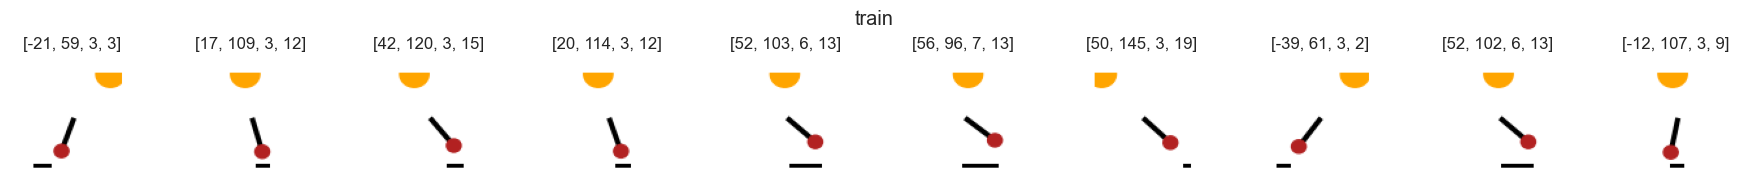

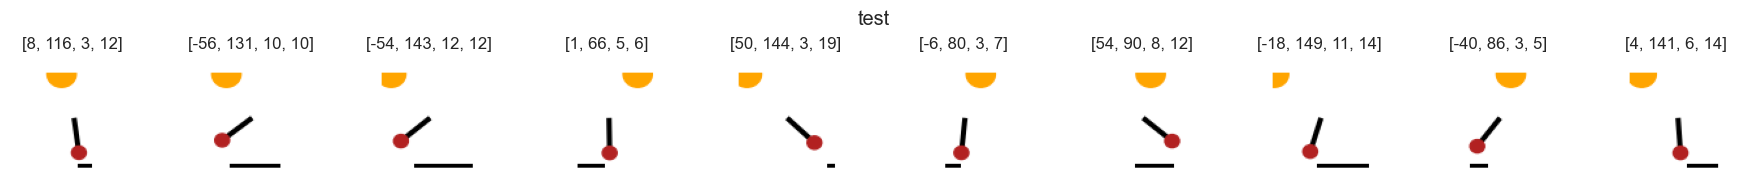

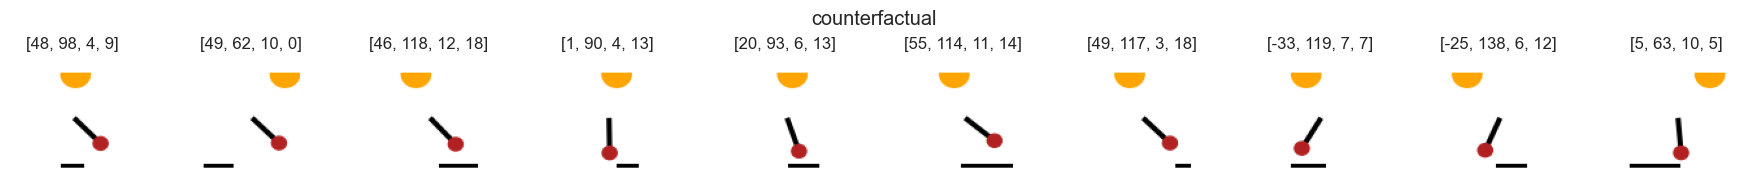

In [14]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [train_dataset, test_dataset, cf_dataset]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

In [15]:
BS = 64
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, drop_last=True) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, drop_last=True)
cf_loader = DataLoader(cf_dataset, batch_size=BS, shuffle=False, drop_last=True)

### 2. Build CVAE

In [16]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3456 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3456 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=96*6*6)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.Upsample((12, 12)),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.Upsample((24, 24)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((48, 48)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.Upsample((96, 96)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.first_layer(z).view((-1, 96, 6, 6))
        return self.upsampling_layers(x)

In [17]:
class CVAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, labels], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(torch.cat([z, labels], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Load trained CVAE

In [18]:
pyro.clear_param_store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CVAE(z_dim=Z_DIM, p=0.1, use_cuda=torch.cuda.is_available())
vae.load_state_dict(torch.load('../../train_CVAE/pendulum_zdim=3/vae_06_08_exp2.pth', map_location='cpu'))

<All keys matched successfully>

### 4. Load trained CAUSICA graph

In [19]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=np.float32)

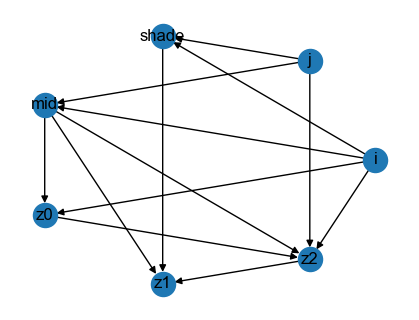

In [20]:
import networkx as nx
labeldict = {i: l for i, l in enumerate(['i', 'j', 'shade', 'mid']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
plt.figure(figsize=(4, 3))
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

### 5. Use trained CAUSICA graph to build SCM

In [21]:
# Getting original image
batch = next(iter(test_loader))
scm_x = batch['img']
scm_y = batch['label']
scm_mu, scm_sigma = vae.encoder(scm_x, scm_y)

In [22]:
class SCM():
    def __init__(self, vardist_mode, z_dim=3, num_labels=4, label_sizes=[1,1,1,1]):
        pyro.clear_param_store()
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, label_sizes + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
#         for Y in Y_parents:
#             onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Y_parents + Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_model(self, sample_dict, a, var_name, obs_vectors, sigmas):
        if var_name in sample_dict:
            return sample_dict, a
        BS = len(list(sigmas.values())[0])
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        if len(parents) == 0:
            if var_name[0] != 'Y':
                a[var_name] = pyro.param('a_'+var_name,
                                        torch.rand((1, self.feat_dims[var_name])),
                                        )
                var_mu = a[var_name].repeat(BS, 1)
        else:
            parent_dim = 1
            Y_parents, Z_parents = [], []
            for parent in parents:
                parent_dim += self.feat_dims[parent]
                sample_dict, a = self.get_sample_model(sample_dict, a, parent, obs_vectors, sigmas)
                if parent[0] == 'Y':
                    Y_parents.append(sample_dict[parent])
                elif parent[0] == 'Z':
                    Z_parents.append(sample_dict[parent])
            a[var_name] = pyro.param('a_'+var_name,
                                     torch.rand((parent_dim, self.feat_dims[var_name]))
                                     )
            var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ a[var_name]
        if var_name[0] == 'Y':
#             sample_dict[var_name] = pyro.sample(var_name, dist.Categorical(logits=var_mu), obs=obs_vectors[var_name])
            sample_dict[var_name] = obs_vectors[var_name]
        else:
            sample_dict[var_name] = pyro.sample(var_name, dist.Normal(var_mu.flatten(), sigmas[var_name]).to_event(1), obs=obs_vectors[var_name])
        return sample_dict, a

    def model(self, sigma, mu, labels):
        sample_dict = {}
        a = {}
        BS = len(sigma)
        sigmas = {k: val for k, val in zip(self.z_names, sigma.T)}
        obs_vectors = {k: val for k, val in zip(self.var_names, torch.cat([labels, mu], dim=1).T)}
        with pyro.plate("data", BS):
            for var_name in self.var_names:
                if var_name not in sample_dict:
                    sample_dict, a = self.get_sample_model(sample_dict, a, var_name, obs_vectors, sigmas)

    def guide(self, sigma, mu, labels):
        pass

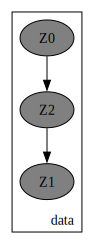

In [23]:
scm = SCM(vardist_mode, z_dim=3)
pyro.render_model(scm.model, model_args=(scm_sigma, scm_mu, scm_y))

In [24]:
pyro.render_model(scm.guide, model_args=(scm_sigma, scm_mu, scm_y))

In [28]:
def callback(train_elbo, last_params):
    size = (len(param_names) + 2) // 3
    f, ax = plt.subplots(size, 3, figsize=(16, size * 3))
    ax = ax.flatten()
    for i, (k, param) in enumerate(last_params.items()):
        sns.heatmap(param, ax=ax[i], annot=True, fmt=".1f" if i == 2 else ".2f")
        ax[i].set_title(k)
    plt.tight_layout()

    epoch = len(train_elbo)
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    plt.xlabel('iteration')
    plt.title(f'Iteration {epoch}. Train ELBO {train_elbo[-1]}')
    plt.show()

In [29]:
pyro.clear_param_store()

adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

svi = SVI(
    model=scm.model,
    guide=scm.guide,
    optim=optimizer,
    loss=Trace_ELBO(retain_graph=True)
)

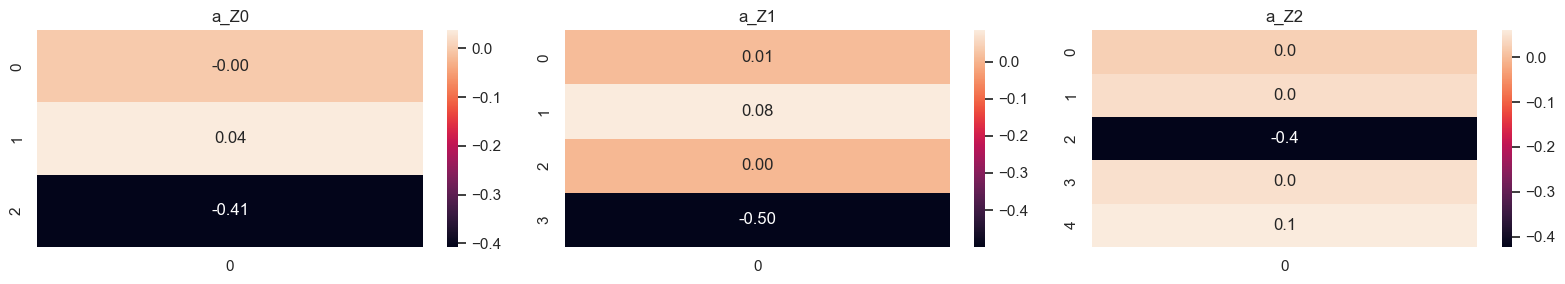

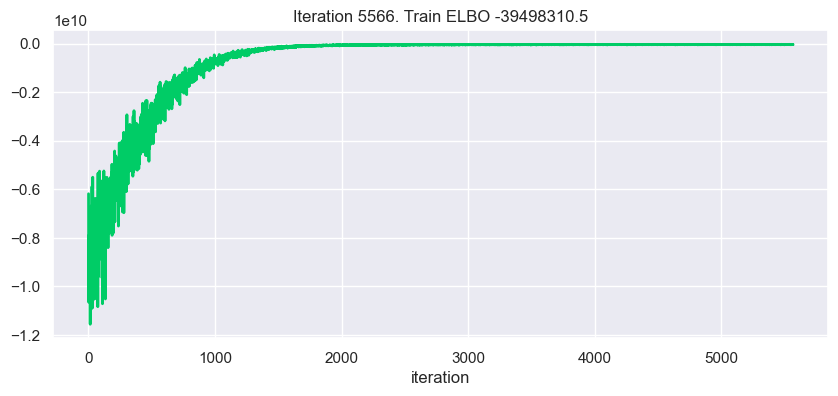

 70%|██████████████████████████████             | 35/50 [41:53<17:57, 71.81s/it]


KeyboardInterrupt: 

In [30]:
num_steps = 50
param_names = ['a_Z'+str(j) for j in range(Z_DIM)]
ELBO_hist = []
last_params = {}

for epoch in tqdm(range(num_steps)):
    for i, batch in enumerate(train_loader):
        scm_x = batch['img']
        scm_y = batch['label']
        scm_mu, scm_sigma = vae.encoder(scm_x, scm_y)
        loss = svi.step(scm_sigma, scm_mu, scm_y)
        ELBO_hist.append(-loss)
        if i % 100 == 0:
            for param_name in param_names:
                last_params[param_name] = pyro.param(param_name).detach().cpu()
            callback(ELBO_hist, last_params)

In [31]:
import pickle
with open('params_zdim3_scm.pkl', "wb") as f:
    pickle.dump(last_params, f)